## Импорты

In [1]:
import datetime
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms
from torchsummary import summary

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import DataLoader, TensorDataset

import cv2

## Подготовка данных

In [2]:
data_raw = pd.read_csv('./data/sign_mnist_train.csv')
test_data_raw = pd.read_csv('./data/sign_mnist_test.csv')

In [3]:
labels = data_raw['label']
data_raw.drop('label', axis=1, inplace=True)
labels_test = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True)

In [4]:
data = data_raw.values
labels = labels.values

test_data = test_data_raw.values
labels_test = labels_test.values

In [5]:
reshaped = []
for i in data:
    reshaped.append(i.reshape(1, 28, 28))
data = np.array(reshaped)

reshaped_test = []
for i in test_data:
    reshaped_test.append(i.reshape(1,28,28))
test_data = np.array(reshaped_test)

In [6]:
label_to_symbvol = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J',
    10: 'K',
    11: 'L',
    12: 'M',
    13: 'N',
    14: 'O',
    15: 'P',
    16: 'Q',
    17: 'R',
    18: 'S',
    19: 'T',
    20: 'U',
    21: 'V',
    22: 'W',
    23: 'X',
    24: 'Y',
    25: 'Z',
}

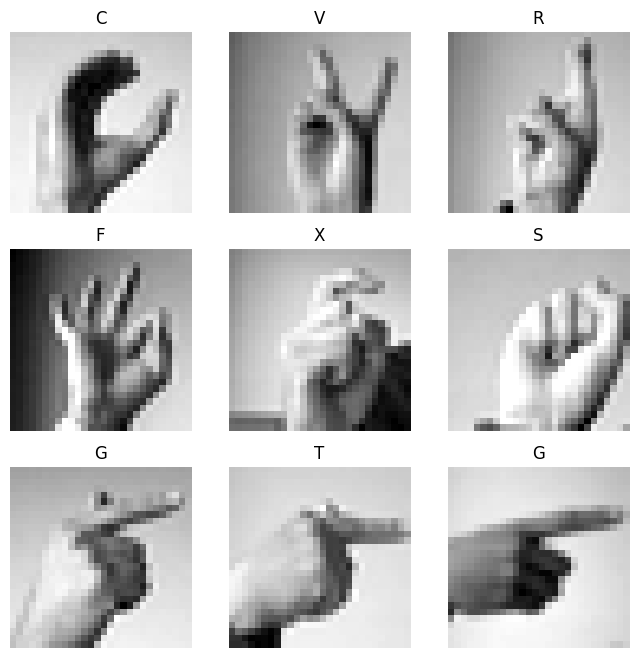

In [7]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx], labels[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label_to_symbvol[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
train_x = torch.FloatTensor(data)/255.0
train_y = torch.LongTensor(labels.tolist())

test_x = torch.FloatTensor(test_data)/255.0
test_y = torch.LongTensor(labels_test.tolist())

In [9]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

In [10]:
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

In [11]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class CNN_BN(nn.Module):
    def __init__(self):
        super(CNN_BN, self).__init__()
        #input 1x28x28
        self.conv1 = nn.Conv2d(1, 224, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(224)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(224, 112, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(112)
        self.conv3 = nn.Conv2d(112, 56, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(56)
        self.dropout = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(56 * 4 * 4, 120)
        self.bn4 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 26)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = x.view(-1, 56*4*4)
        x = self.bn4(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = CNN_BN()

In [13]:
summary(model.to(torch.device('cuda')), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 224, 28, 28]           2,240
       BatchNorm2d-2          [-1, 224, 28, 28]             448
         MaxPool2d-3          [-1, 224, 14, 14]               0
            Conv2d-4          [-1, 112, 14, 14]         225,904
       BatchNorm2d-5          [-1, 112, 14, 14]             224
         MaxPool2d-6            [-1, 112, 7, 7]               0
            Conv2d-7             [-1, 56, 8, 8]          25,144
       BatchNorm2d-8             [-1, 56, 8, 8]             112
         MaxPool2d-9             [-1, 56, 4, 4]               0
        Dropout2d-10             [-1, 56, 4, 4]               0
           Linear-11                  [-1, 120]         107,640
      BatchNorm1d-12                  [-1, 120]             240
           Linear-13                   [-1, 84]          10,164
           Linear-14                   

In [14]:
def test_eval(model, test_dataloader, device):
    total_samples, correct_samples = 0, 0
    model.eval() 
    with torch.no_grad():
        for x, y in test_dataloader:
            x = x.to(device)
            y = y.to(device)

            pred = model(x)
            _, indices = torch.max(pred, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

    accuracy = (float(correct_samples)/total_samples)*100
    print(f'🤩Точность на тесте {accuracy}')
    return accuracy

In [15]:
def train(model, train_dataloader, val_dataloader, loss_fn=nn.CrossEntropyLoss(), 
          optimizer=None, test_dataloader=None, scheduler=None, 
          device_value=None, fail_stop=10, test_every=10,
          epoch_num=10):
    try:
        if(not optimizer):
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        if(not device_value):
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            device = torch.device(device_value)
        model.to(device)

        best_val_loss = float('inf')
        best_epoch_i = 0
        best_model = copy.deepcopy(model)


        for epoch in range(1, epoch_num+1):
                epoch_start = datetime.datetime.now()
                print(f'Эпоха {epoch}')

                model.train()
                mean_train_loss = 0
                train_batches_n = 0

                for i, (x, y) in enumerate(train_dataloader):
                    x = x.to(device)
                    y = y.to(device)

                    pred = model(x)
                    loss = loss_fn(pred, y)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    mean_train_loss += float(loss)
                    train_batches_n += 1

                mean_train_loss /= train_batches_n
                print(f'Эпоха: {i} итераций, {(datetime.datetime.now() - epoch_start).total_seconds()} сек')
                print(f'Среднее значение потерь: {mean_train_loss}')


                # оценка

                model.eval()
                mean_val_loss = 0
                val_batches_n = 0

                with torch.no_grad():
                    for x, y in val_dataloader:
                        x = x.to(device)
                        y = y.to(device)

                        pred = model(x)
                        loss = loss_fn(pred, y)

                        mean_val_loss += float(loss)
                        val_batches_n += 1

                mean_val_loss /= val_batches_n
                print(f'Среднее значение потерь на валидации: {mean_val_loss}')


                if(mean_val_loss < best_val_loss):
                    best_val_loss = mean_val_loss
                    best_epoch_i = epoch
                    best_model = copy.deepcopy(model)
                    print('🦾Модель улучшилась!')
                elif(epoch - best_epoch_i >= fail_stop):
                    print(f'✋Модель не улучшалась последние {fail_stop} эпох! Стоп машина!')
                    break

                if scheduler is not None:
                    scheduler.step(mean_val_loss)

                if(test_dataloader):
                    if(epoch % test_every == 0):
                        test_eval(best_model, test_dataloader, device=device)
    except KeyboardInterrupt:
        print('Остановлено пользователем')
    except Exception as ex:
        print(ex)
    finally:
        return best_val_loss, best_model

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

In [17]:
best_loss, model = train(model, train_dataloader, val_dataloader, loss_fn=nn.CrossEntropyLoss(), 
                         optimizer=optimizer, test_dataloader=test_dataloader, scheduler=scheduler, 
                         device_value=None, fail_stop=10, test_every=10,
                         epoch_num=100)

Эпоха 1
Эпоха: 686 итераций, 7.525695 сек
Среднее значение потерь: 0.861465664615711
Среднее значение потерь на валидации: 0.0277722324407118
🦾Модель улучшилась!
Эпоха 2
Эпоха: 686 итераций, 7.261198 сек
Среднее значение потерь: 0.08039313454921133
Среднее значение потерь на валидации: 0.010495842972548332
🦾Модель улучшилась!
Эпоха 3
Эпоха: 686 итераций, 7.296677 сек
Среднее значение потерь: 0.039755838152137755
Среднее значение потерь на валидации: 0.003275598187830711
🦾Модель улучшилась!
Эпоха 4
Эпоха: 686 итераций, 7.38329 сек
Среднее значение потерь: 0.04150325600696684
Среднее значение потерь на валидации: 0.0014017145863045846
🦾Модель улучшилась!
Эпоха 5
Эпоха: 686 итераций, 7.075174 сек
Среднее значение потерь: 0.028093182345753295
Среднее значение потерь на валидации: 0.000595412039623371
🦾Модель улучшилась!
Эпоха 6
Эпоха: 686 итераций, 7.363813 сек
Среднее значение потерь: 0.02543674889725553
Среднее значение потерь на валидации: 0.0009268704159398493
Эпоха 7
Эпоха: 686 итерац

Эпоха: 686 итераций, 7.463961 сек
Среднее значение потерь: 0.0001702633906813449
Среднее значение потерь на валидации: 7.391955624734386e-08
✋Модель не улучшалась последние 10 эпох! Стоп машина!


In [18]:
test_eval(model, test_dataloader, torch.device('cuda'))

🤩Точность на тесте 98.73117679866145


98.73117679866145

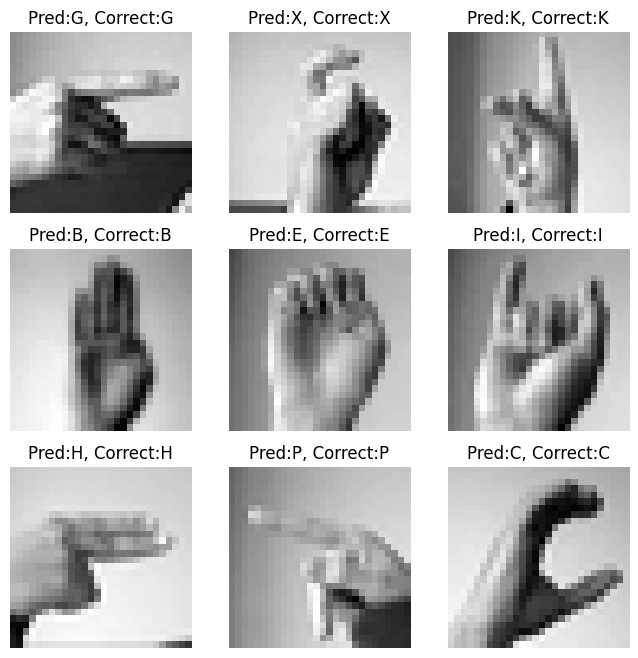

In [19]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = test_dataset[sample_idx]
    label = label.item()
    pred = model(img.to(torch.device('cuda')).unsqueeze(0))
    _, indices = torch.max(pred, 1)
    pred = indices[0].item()
    
    figure.add_subplot(rows, cols, i)
    if(pred == label):
        plt.title(f'Pred:{label_to_symbvol[pred]}, Correct:{label_to_symbvol[label]}')
    else:
        plt.title(f'Pred:{label_to_symbvol[pred]}, Correct:{label_to_symbvol[label]}')
    plt.axis("off")
    plt.imshow(img.view(28,28), cmap="gray")
plt.show()